In [489]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, log10, cos, atan2, hypot
from FT_model import model_FT
from copy import deepcopy

image_path = "Images/"

def test_quality(wf, npixels=1024, radius=10):
    """
    Runs the FT and analysis on the wavefront
    Return the max of out outer region if the central peak brightness is less that the outer
    Else returns -1
    """
    FT = model_FT(wf, aperture*1e-3, npixels, [wl], fl, detector_pitch)
    central, outer = split_central(FT, npixels, radius)
    Q = get_Q(central, outer)
        
#     return outer.max(), Q, FT
    return FT.max(), Q, FT

def display(wf, image, size=200, sizes=(12,6), save='', mod=False, C=0):
    fig, axs = plt.subplots(1, 2, figsize=sizes)
    
    if not mod:
        im = axs[0].imshow(np.abs(np.angle(wf)))
    else:
        im = axs[0].imshow(np.abs(wf))
#     plt.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)
    
    c = image.shape[0]/2
    im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
    d = size//2
    circle = plt.Circle((0, 0), C, color='r', fill=False)
    axs[1].add_artist(circle)
    im = axs[1].imshow(im_out, extent=[-d,d,-d,d])
    
    
    
#     plt.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)
    
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=25)
    
    if save != '':
        fig.tight_layout()
        fig.savefig(image_path + "{}.jpg".format(save), bbox_inches='tight')
        
    plt.show()
    
def split_central(image, npixels, radius):
    central = np.zeros([npixels, npixels], dtype = np.float)
    outer = np.zeros([npixels, npixels], dtype = np.float)
    c = npixels//2
    for i in range(npixels):
        for j in range(npixels):
            x = i - c
            y = j - c
            r = hypot(x,y)
            if r <= radius:
                central[i][j] = image[i][j]
            else:
                outer[i][j] = image[i][j]
    return central, outer 

def get_Q(central, outer, mod=False):
    """
    Gets the "quality factor" defined as the ratio of the peak brightnesses of the central and outer region.
    A value closer to zero indicates that the peak brightnesses is similar in both regions
    A value above zero indicated a higher peak power in the outer region, below zero indicates higher peak in central region
    mod returns the absolute value of Q, |Q|
    """
    max_central = central.max()
    max_outer = outer.max()
    if not mod:
        return max_outer/max_central - 1
    return np.abs(max_outer/max_central - 1)

In [438]:
def generate_new(N=40, p=0.5):
    return np.reshape(np.random.choice(a=[0, 1], size=(1, N), p=[p, 1-p])[0], (4, 5, 2))

def flip1(settings):
    r1 = np.random.randint(0, high=4)
    r2 = np.random.randint(0, high=5)
    r3 = np.random.randint(0, high=2)
    settings[r1][r2][r3] = np.abs(settings[r1][r2][r3] - 1)
    return settings
    
def flip2(settings):
    r1 = np.random.randint(0, high=4)
    r2 = np.random.randint(0, high=5)
    settings[r1][r2][0] = np.abs(settings[r1][r2][0] - 1)
    settings[r1][r2][1] = np.abs(settings[r1][r2][1] - 1)
    return settings

def get_value(settings, i=-1, splits=[15.15, 12.4, 10.17, 8.33, 6.83, 5.6, 3.75, 3.05, 2.5, 2.07, 1.7, 1.4, 1.14, 0.925, 0.76, 0.62]):
    aperture = 0.015                 # Aperture (m)
    gridsize = 1024                  # Gridsize of the wavefront array
    npixels = 1024                   # Size of detector, in pixels
    wl = 0.525e-9                    # Wavelength values (micrometers)
    fl = 0.15                        # Focal length (m)
    detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)

#     split_values = [15.15, 12.4, 10.17, 8.33, 6.83, 5.6]
#     split_values = [15.15, 12.4, 10.17, 8.33, 6.83, 5.6, 3.75, 3.05, 2.5, 2.07, 1.7, 1.4, 1.14, 0.925, 0.76, 0.62]
    r_max = split_values[0]
    r_min = split_values[i]
#     splits = split_values
    
    wf = generate_spiral(gridsize, aperture*1e3, r_max, r_min, splits, settings)
    FT = model_FT(wf, aperture*1e-3, npixels, [wl], fl, detector_pitch)
    
    return wf, FT, FT.max()

def restore_balance(settings):
    for s in range(len(settings[0])):
        total = sum([sum(settings[i][s]) for i in range(len(settings))])
        even = sum([len(settings[i][s]) for i in range(len(settings))])//2
        
        # If the pupil is unbalanced
        while total != even:
            r1 = np.random.randint(0, high=4)
            r3 = np.random.randint(0, high=2)
            # Flip towards balance until an even match is reached
            if total > even and settings[r1][s][r3] == 1:
                settings[r1][s][r3] = 0 
            if total < even and settings[r1][s][r3] == 0:
                settings[r1][s][r3] = 1 
            # Update total
            total = sum([sum(settings[i][s]) for i in range(len(settings))])
    return settings

def flip_whole(settings):
    new_settings = deepcopy(settings)
    r1 = np.random.randint(0, high=4)
    R = np.random.randint(0, high=6)
    
    if R == 0:
        new_settings[r1][R][0] = np.abs(settings[r1][R][0] - 1)
    elif R == 5:
        new_settings[r1][R-1][1] = np.abs(settings[r1][R-1][1] - 1)
    else:
        new_settings[r1][R-1][1] = np.abs(settings[r1][R-1][1] - 1)
        new_settings[r1][R][0] = np.abs(settings[r1][R][0] - 1)
        
    return new_settings

In [474]:
def generate_spiral(gridsize, aperture, r_max, r_min, splits, settings):
    split = splits
    first = settings[0]
    second = settings[1]
    third = settings[2]
    fourth = settings[3]
    
    sampling = aperture/(gridsize//2)
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            phi = atan2(y, x)
            r = sampling*hypot(x,y)
            wfarr[i][j] = spiral(r, phi, aperture, r_max, r_min, split, first, second, third, fourth)
    return wfarr

def spiral(r, phi, aperture, r_max, r_min, split, first, second, third, fourth):
    # Spiral parameters
    alpha1 = 20.186
    m1 = 5
    eta1 = -1.308
    m2 = -5
    alpha2 = 16.149
    eta2 = -0.733
    m3 = 10
    alpha3 = 4.0372
    eta3 = -0.575
    
    white = np.complex(1,0)
    black = -np.complex(1,0)
    v = np.complex(0,0)
    offset = np.complex(-(3**0.5)/2,1/2)
#     black = offset

    if (r<=r_max and r>r_min):
        logr = log10(r)
        chi1 = alpha1*logr+m1*phi+eta1
        c1 = cos(chi1)
        chi2 = alpha2*logr+m2*phi+eta2
        c2 = cos(chi2)
        chi3 = alpha3*logr+m3*phi+eta3
        c3 = sin(chi3)
        
        z = 0 if (c1*c2*c3>0) else 1 
        for i in range(len(split)):
            if (r <= split[i] and r > split[i+1]): # Finds which region we are in
                
                if i%2 != 0:
                    z = np.abs(z-1)
                
                # First quadrant
                if c3 < 0 and sin(chi3/2.) <= 0:
                    return black if first[i][z] else white

                # Second qudrant
                elif c3 >= 0 and sin(chi3/2.) <= 0:
                    return black if second[i][np.abs(z-1)] else white
#                     return black if second[i][z] else white
                
                # Third quadrant
                elif c3 < 0 and sin(chi3/2.) > 0:
                    return black if third[i][z] else white
        
                # Fourth qudrant
                else: 
                    return black if fourth[i][np.abs(z-1)] else white
#                     return black if fourth[i][z] else white
#             else:
#                 print("Missing Values")
                    
    elif r < r_min:
#         v = black
        v = np.complex(0,0)
    return v

In [485]:
aperture = 0.015                 # Aperture (m)
gridsize = 1024                  # Gridsize of the wavefront array
npixels = 1024                   # Size of detector, in pixels
wl = 0.525e-9                    # Wavelength values (micrometers)
fl = 0.15                        # Focal length (m)
detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)

split_values = [15.15, 12.4, 10.17, 8.33, 6.83, 5.6]
r_max = split_values[0]
r_min = split_values[-1]

first  = [[1,0],[0,1],[1,0],[0,1],[1,0]]
second = [[1,1],[1,0],[0,1],[1,0],[0,1]]
third  = [[1,0],[0,1],[1,0],[0,1],[1,0]]
fourth = [[0,1],[1,0],[0,1],[1,0],[0,1]]

splits = split_values
settings = [first, second, third, fourth]

In [486]:
split_values = [15.15, 12.4, 10.17, 8.33, 6.83, 5.6, 4.6, 3.75, 3.05, 2.5, 2.07, 1.7, 1.4, 1.14, 0.925, 0.76, 0.62]

first  = [[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,0],[0,1],[1,0],[0,1]]
second = [[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,1],[0,1],[1,0],[0,1],[1,1]]
third  = [[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,0],[0,1],[1,0],[0,1]]
fourth = [[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,1],[0,1],[1,0],[0,1],[1,1]]
settings = [first, second, third, fourth]

H: 110.17790


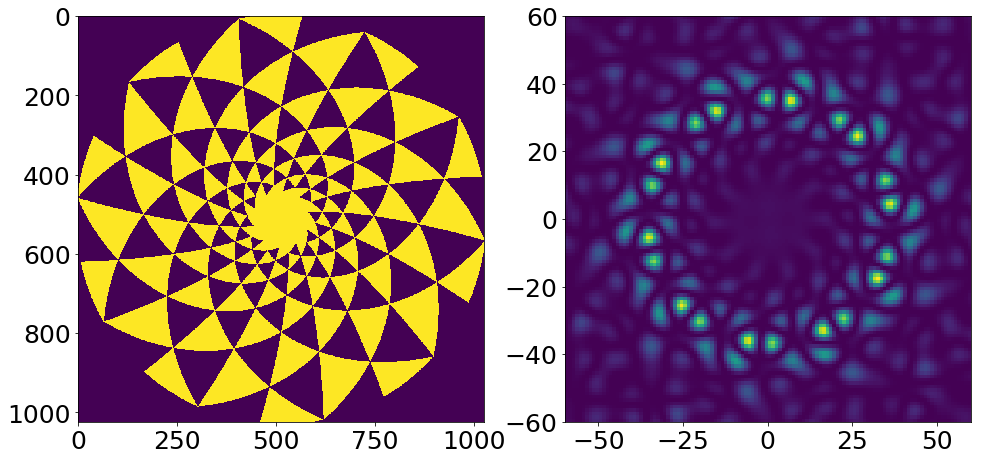

In [141]:
wf, FT, val = get_value(settings, i=-5, splits=split_values)
print("H: {:.5f}".format(val*1e-8))
display(wf, FT, sizes=(16,16), size=120)

In [449]:
#### wf, FT, val = get_value(settings)
# print("H: {:.5f}".format(val*1e-8))
# display(wf, FT, sizes=(8,8), size=120, save='BR_flipped')

In [450]:
# wf, FT, val = get_value(settings)
# print("H: {:.5f}".format(val*1e-8))

# sizes = (8,8)
# fig, axs = plt.subplots(1, 1, figsize=sizes)
# im = axs.imshow(np.abs(np.abs(wf)))
# # plt.colorbar(im,ax=axs,fraction=0.046, pad=0.04)
# axs.tick_params(axis='both', which='major', labelsize=25)
# # fig.savefig(image_path + "Power.jpg", bbox_inches='tight')
# plt.show()

---
### Potential pupils found

(Anything below 50)

In [514]:
h0 = [[1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0]], [[1, 1], [0, 1], [1, 0], [1, 0], [1, 1], [1, 1]], [[1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0]], [[0, 1], [0, 1], [0, 0], [1, 0], [0, 0], [0, 0]]
h1 = [[0, 1], [1, 0], [1, 0], [0, 0], [0, 1], [0, 1]], [[1, 0], [1, 0], [0, 1], [0, 0], [0, 1], [0, 1]], [[1, 0], [1, 0], [1, 0], [1, 1], [0, 0], [0, 0]], [[1, 0], [0, 1], [0, 1], [1, 1], [1, 1], [1, 1]]
# h2 = [[0, 1], [0, 1], [1, 0], [0, 0], [1, 0], [1, 0]], [[1, 1], [1, 0], [0, 1], [1, 1], [0, 1], [0, 1]], [[0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0]], [[0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1]]
h2 = [[0, 1], [0, 1], [1, 0], [0, 0], [1, 0], [1, 0]], [[0, 1], [1, 0], [0, 1], [1, 1], [0, 1], [0, 1]], [[0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0]], [[0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1]]
h3 = [[0, 1], [1, 0], [1, 1], [0, 1], [0, 0], [0, 0]], [[0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1]], [[0, 0], [1, 1], [1, 0], [1, 0], [1, 0], [1, 0]], [[1, 1], [0, 0], [1, 0], [1, 0], [1, 1], [1, 1]]
# h4 = [[0, 1], [0, 1], [0, 0], [0, 0], [1, 1]], [[1, 1], [0, 1], [1, 0], [1, 1], [0, 0]], [[1, 0], [0, 1], [0, 0], [0, 0], [0, 0]], [[1, 0], [1, 0], [0, 1], [0, 1], [0, 1]]
# h5 = [[1, 0], [0, 1], [0, 1], [0, 0], [1, 1]], [[0, 1], [0, 0], [0, 1], [0, 1], [1, 1]], [[0, 1], [1, 0], [1, 0], [0, 0], [1, 0]], [[0, 1], [1, 1], [0, 1], [1, 0], [1, 0]]
# h6 = [[0, 1], [1, 0], [0, 1], [0, 0], [1, 1]], [[1, 0], [1, 0], [1, 1], [0, 0], [1, 0]], [[0, 1], [0, 1], [1, 1], [1, 0], [1, 1]], [[1, 0], [0, 0], [0, 0], [1, 0], [0, 1]]
# h7 = [[0, 0], [1, 1], [0, 0], [1, 1], [1, 1]], [[1, 0], [0, 0], [1, 0], [0, 0], [1, 1]], [[1, 0], [1, 0], [0, 0], [1, 0], [0, 1]], [[1, 1], [0, 0], [1, 1], [0, 1], [0, 1]]

# H = [h0, h1, h2, h3, h4, h5, h6, h7]
H = [h0, h1, h2, h3]

H: 41.42939


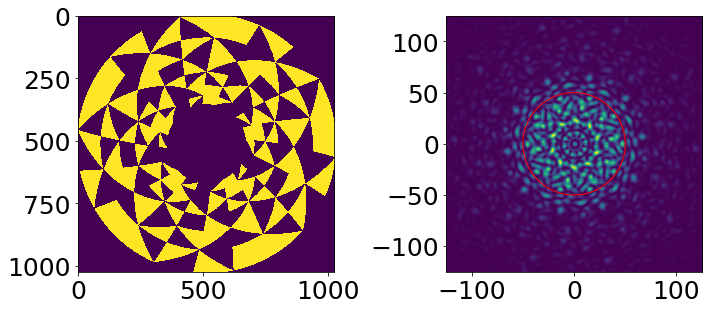

H: 35.53463


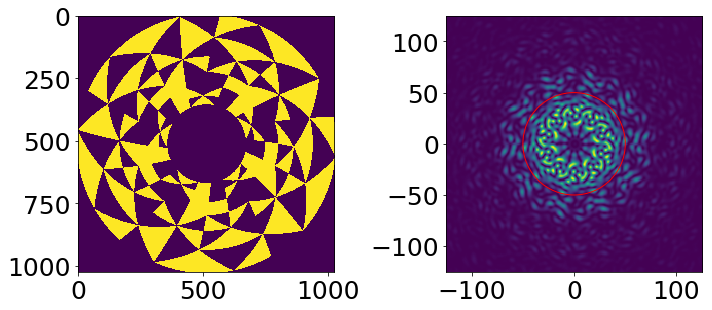

H: 54.48693


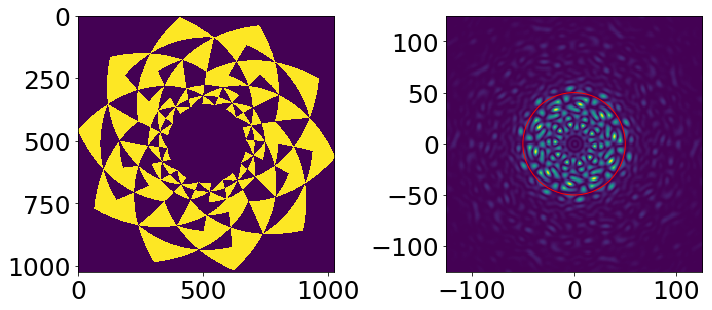

H: 42.39839


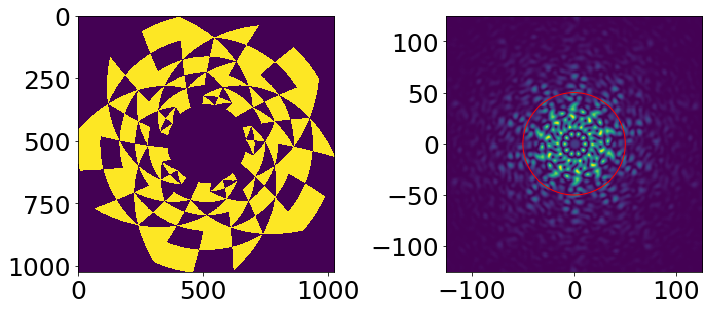

In [515]:
i = 0
for h in H:
    wf, FT, val = get_value(h, i=-11)
    print("H: {:.5f}".format(val*1e-8))
    display(wf, FT, sizes=(10,10), size=250, save="half{}".format(i), mod=False, C=50)
    i += 1

---
### Potential pupils found

(Anything below 60)

In [506]:
f0 = [[1, 0], [0, 1], [1, 1], [1, 1], [1, 0]], [[1, 0], [0, 0], [0, 1], [1, 0], [0, 1]], [[1, 0], [0, 1], [1, 0], [0, 1], [1, 1]], [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]]
f1 = [[1, 0], [0, 1], [1, 1], [1, 1], [1, 1]], [[1, 0], [0, 0], [0, 1], [1, 0], [0, 0]], [[1, 0], [0, 1], [1, 0], [0, 1], [1, 1]], [[0, 1], [1, 0], [0, 1], [1, 0], [0, 0]]
f2 = [[1, 0], [0, 1], [1, 0], [0, 1], [1, 1]], [[1, 0], [0, 0], [0, 1], [1, 0], [0, 0]], [[1, 0], [0, 1], [1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [0, 1], [1, 0], [0, 0]]
f3 = [[0, 0], [0, 1], [1, 1], [1, 1], [1, 0]], [[1, 1], [1, 0], [0, 1], [1, 0], [0, 1]], [[1, 0], [0, 1], [1, 0], [0, 1], [1, 1]], [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]]
# f4 = [[0, 0], [0, 1], [1, 0], [0, 1], [1, 0]], [[1, 1], [1, 0], [0, 1], [1, 0], [0, 0]], [[1, 0], [0, 1], [1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]]
# f5 = [[0, 0], [0, 1], [1, 0], [0, 1], [1, 0]], [[1, 1], [1, 0], [0, 1], [1, 0], [0, 1]], [[1, 0], [0, 1], [1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [0, 1], [1, 0], [0, 0]]
# f6 = [[1, 0], [0, 1], [1, 0], [0, 1], [1, 0]], [[1, 0], [0, 0], [0, 1], [1, 0], [0, 0]], [[1, 0], [0, 1], [1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [0, 1], [1, 0], [0, 0]]
# f7 = [[1, 0], [0, 1], [1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]], [[0, 1], [1, 1], [1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]]

# F = [f0, f1, f2, f3, f4, f5, f6, f7]
F = [f0, f1, f2, f3]

H: 52.01438


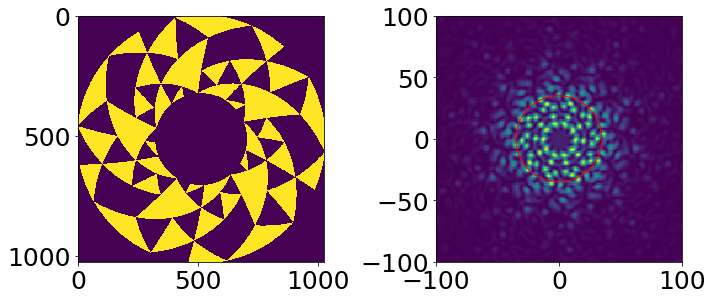

H: 52.13392


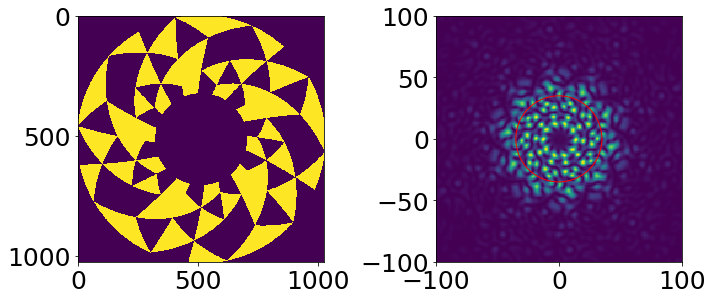

H: 52.99353


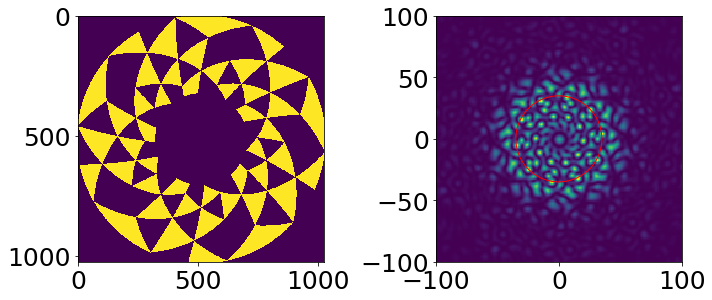

H: 53.87736


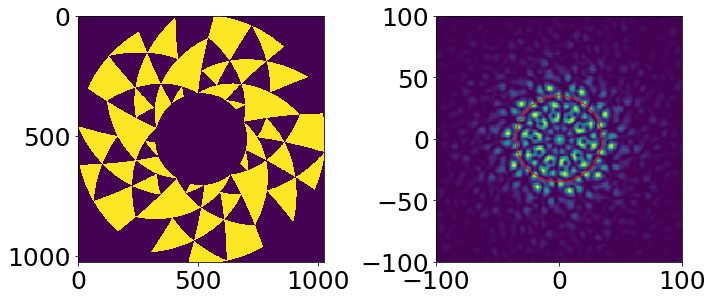

In [507]:
i = 0
for f in F:
    wf, FT, val = get_value(f, i=-12)
    print("H: {:.5f}".format(val*1e-8))
    display(wf, FT, sizes=(10,10), size=200, save="whole{}".format(i), mod=False, C=35)
    i += 1

In [508]:
# f = f1
# wf, FT, val = get_value(f)
# sizes = (10,10)
# fig, axs = plt.subplots(1, 1, figsize=sizes)
# im = axs.imshow(np.abs(np.angle(wf)))
# axs.tick_params(axis='both', which='major', labelsize=25)
# fig.savefig(image_path + "Whole_ex.jpg", bbox_inches='tight')
# plt.show()

In [509]:
# h = h0
# wf, FT, val = get_value(h)
# sizes = (10,10)
# fig, axs = plt.subplots(1, 1, figsize=sizes)
# im = axs.imshow(np.abs(np.angle(wf)))
# axs.tick_params(axis='both', which='major', labelsize=25)
# fig.savefig(image_path + "Half_ex.jpg", bbox_inches='tight')
# plt.show()